In [72]:
# importing packages
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest
from CP2LFI.scores import LambdaScore
from clover import Scores
from clover import LocartSplit
from copy import deepcopy
from tqdm import tqdm
from scipy import stats
from scipy.optimize import minimize_scalar
import time
import itertools

In [73]:
np.linspace((50, 2), (150, 8), 2)

array([[ 50.,   2.],
       [150.,   8.]])

## Old example

description of the experiment

In [74]:
# simulator
def sim_gamma(n,gamma_shape, gamma_scale, X=None):
    normal_mean = gamma_shape*gamma_scale
    normal_std = np.sqrt(gamma_shape)*gamma_scale 
    
    random_x = X if X is not None else np.random.uniform(0, 1, n)
    diff = list()

    for x in random_x:
        q_gamma = stats.gamma.ppf(x, a=gamma_shape, scale=gamma_scale)
        q_normal = stats.norm.ppf(x, normal_mean, normal_std)
        diff.append(abs(q_gamma - q_normal))

    if n == 1:
        return diff[0]
    return diff


# randomly sampling from gamma
def sample_gamma(n, N, thetas, seed=1000):
    #np.random.seed(seed)
    
    lambdas = np.zeros(n)
    i = 0
    for (shape, scale) in thetas:
        lambdas[i] = sim_gamma(1, shape, scale)
        i += 1
    return lambdas


# naive method
def naive(alpha, B=1000, N=100, seed=250, naive_n=100):
    np.random.seed(seed)
    n_grid = int(B / naive_n)

    grid = np.linspace((50, 2), (90, 5), n_grid)
    
    quantiles = {}
    for params in tqdm(grid,  desc="Obtaining naive quantiles"):
        shape = params[0]
        scale = params[1]
        X_stat = sim_gamma(N, shape, scale)
        quantiles[(shape, scale)] = np.quantile(X_stat, q=1 - alpha)
    return quantiles


# naive predict function
def predict_naive_quantile(theta_grid, quantiles_dict):
    lambda_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for x in theta_grid:
        distances = np.linalg.norm(lambda_values - x, axis=1)
        idx = lambda_values[np.argmin(distances)]
        quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list

In [75]:
def evaluate_coverage(quantiles_dict, thetas, alpha=0.05, n=500, N=100):
    err_data = np.zeros((thetas.shape[0], 4))
    coverage_data = np.zeros((thetas.shape[0], 4))
    j = 0
    for theta in tqdm(thetas, desc="Computing coverage for each method"):
        # generating several lambdas
        stat = np.zeros(n)
        for i in range(0, n):
            stat[i] = sample_gamma(n = 1, N = N, thetas=theta.reshape(-1, 2))
        # comparing coverage of methods
        locart_cover = np.mean(stat <= quantiles_dict["locart"][j])
        loforest_cover = np.mean(stat <= quantiles_dict["loforest"][j])
        boosting_cover = np.mean(stat <= quantiles_dict["boosting"][j])
        naive_cover = np.mean(stat <= quantiles_dict["naive"][j])

        # appending the errors
        err_locart = np.abs(locart_cover - (1 - alpha))
        err_loforest = np.abs(loforest_cover - (1 - alpha))
        err_boosting = np.abs(boosting_cover - (1 - alpha))
        err_naive = np.abs(naive_cover - (1 - alpha))

        # saving in numpy array
        err_data[j, :] = np.array([err_locart, err_loforest, err_boosting, err_naive])
        coverage_data[j, :] = np.array(
            [locart_cover, loforest_cover, boosting_cover, naive_cover]
        )
        j += 1

    # obtaining MAE and standard error for each method
    mae_vector, std_vector = np.mean(err_data, axis=0), np.std(err_data, axis=0)
    stats_data = pd.DataFrame(
        {
            "methods": ["LOCART", "LOFOREST", "boosting", "naive"],
            "MAE": mae_vector,
            "str": std_vector / (np.sqrt(thetas.shape[0])),
        }
    )

    coverage_data = pd.DataFrame(
        {
            "thetas": [str(tuple(row)) for row in thetas],
            "LOCART": coverage_data[:, 0],
            "LOFOREST": coverage_data[:, 1],
            "boosting": coverage_data[:, 2],
            "naive": coverage_data[:, 3],
        }
    )
    return [stats_data, coverage_data]

In [76]:
N, B, alpha = 100, 1000, 0.05

In [77]:
N, B, alpha = 100, 1000, 0.05

start_time = time.time()
naive_quantiles = naive(alpha, B = B, N = N)
end_time = time.time()

running_time = end_time - start_time
print(f"Naive running time: {running_time} seconds.")

Obtaining naive quantiles: 100%|██████████| 10/10 [00:00<00:00, 71.64it/s]

Naive running time: 0.14307880401611328 seconds.


In [78]:
grid = np.linspace((50, 2), (150, 8), B)
model_lambdas = sample_gamma(n = B, N = N, thetas = grid, seed = 45)
model_thetas = grid.reshape(-1, 2)

In [79]:
start_time = time.time()
locart_object = LocartSplit(LambdaScore, None, alpha = alpha, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 100)
end_time = time.time()
print(f"LOCART running time: {end_time - start_time} seconds.")

# loforest quantiles
start_time = time.time()
loforest_object = ConformalLoforest(LambdaScore, None, alpha = alpha, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 300)
end_time = time.time()
print(f"LOFOREST running time: {end_time - start_time} seconds.")

# boosting quantiles
start_time = time.time()
model = HistGradientBoostingRegressor(loss="quantile", max_iter = 1000,
quantile = 1 - alpha, random_state = 105, n_iter_no_change = 20, early_stopping = True)
model.fit(model_thetas, model_lambdas)
end_time = time.time()
print(f"Boosting running time: {end_time - start_time} seconds.")

LOCART running time: 0.0060825347900390625 seconds.
LOFOREST running time: 0.10820555686950684 seconds.
Boosting running time: 0.06822776794433594 seconds.


In [80]:
# naive quantiles
naive_list = predict_naive_quantile(grid, naive_quantiles)

# locart quantiles
idxs = locart_object.cart.apply(grid.reshape(-1, 2))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

# loforest
loforest_cutoffs = loforest_object.compute_cutoffs(grid.reshape(-1, 2))

# boosting
boosting_quantiles = model.predict(grid.reshape(-1, 2))

# dictionary of quantiles
quantile_dict = {
    "naive": naive_list,
    "locart": list_locart_quantiles,
    "loforest": loforest_cutoffs,
    "boosting": boosting_quantiles,
}

In [81]:
cover_data = evaluate_coverage(quantile_dict, grid, n = 1000)

Computing coverage for each method: 100%|██████████| 1000/1000 [02:23<00:00,  6.99it/s]


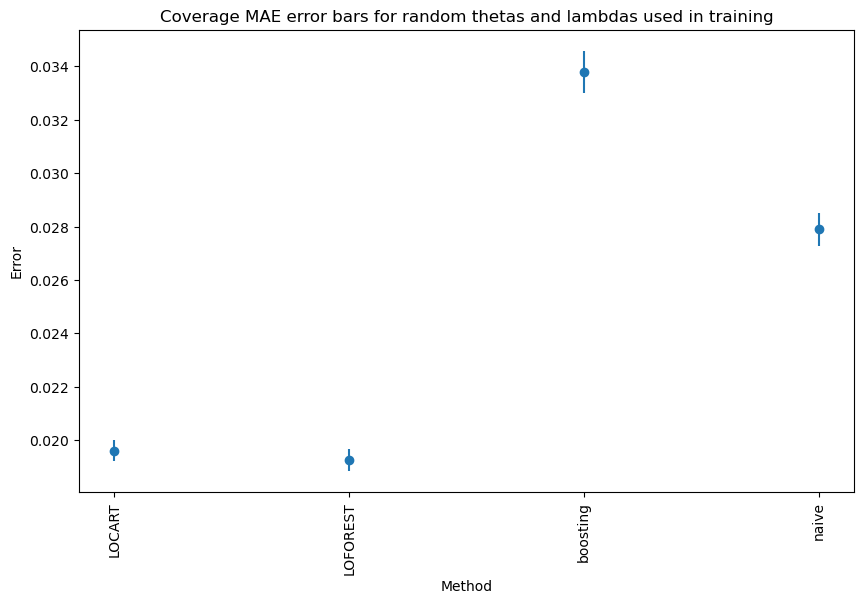

In [82]:
#| echo: false
keys = cover_data[0].iloc[:, 0].values
mae = cover_data[0].iloc[:, 1].values
std_err = cover_data[0].iloc[:, 2].values

plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars for random thetas and lambdas used in training')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


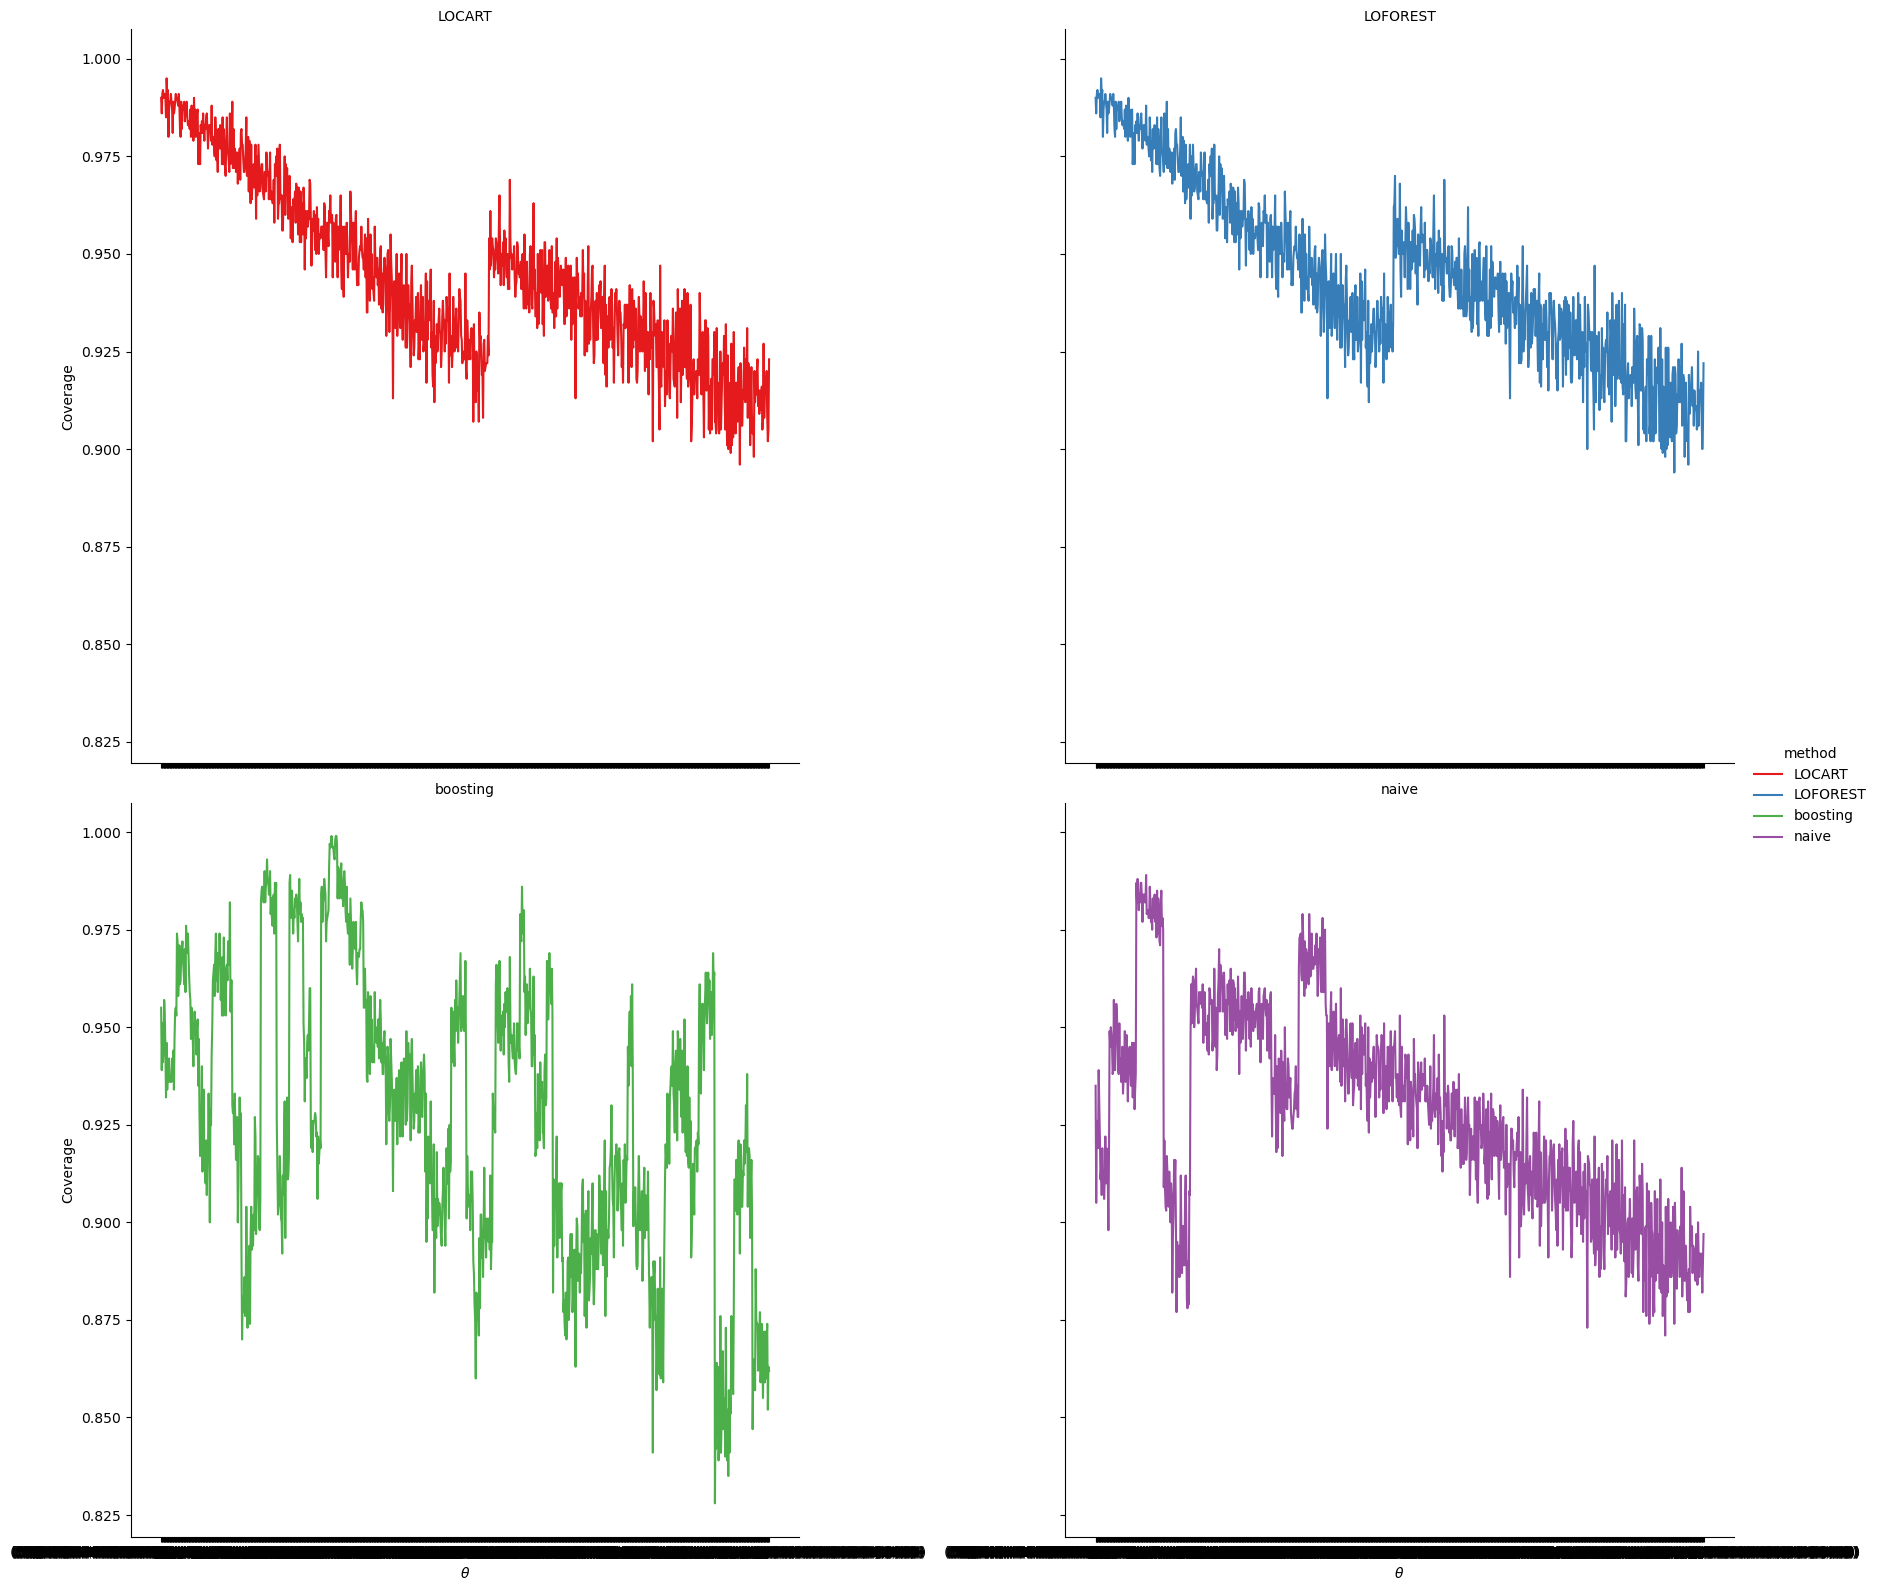

In [83]:
#| echo: false
# Melt the coverage data
coverage_data_melted = pd.melt(
    cover_data[1], id_vars=["thetas"], var_name="method", value_name="coverage")
# Plot the coverage as function of the thetas generated
g = sns.FacetGrid(coverage_data_melted, col="method", hue = "method",
 col_wrap = 2, height=8, aspect=1.10, palette = "Set1")
g.map(sns.lineplot, "thetas", "coverage")
g.add_legend()
g.set_titles("{col_name}")
g.set_xlabels(r"$\theta$")
g.set_ylabels("Coverage")
plt.show()

In [84]:
# function to compute all quantiles in a theta grid
def obtain_quantiles(
    thetas, N, B=1000, alpha=0.05, naive_seed=45, min_samples_leaf=100, naive_n=500
):
    # fitting and predicting naive
    naive_quantiles = naive(alpha=alpha, B=B, N=N, naive_n=naive_n)
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # simulating to fit models
    model_lambdas = sample_gamma(n=B, thetas=thetas, N=N, seed=45)
    model_thetas = thetas.reshape(-1, 2)

    locart_object = LocartSplit(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    locart_quantiles = locart_object.calib(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf
    )

    # loforest quantiles
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    loforest_object.calibrate(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf
    )

    # boosting quantiles
    model = HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile=1 - alpha,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
    model.fit(model_thetas, model_lambdas)

    # naive quantiles
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # locart quantiles
    idxs = locart_object.cart.apply(thetas.reshape(-1, 2))
    list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 2))

    # boosting
    boosting_quantiles = model.predict(thetas.reshape(-1, 2))

    # dictionary of quantiles
    quantile_dict = {
        "naive": naive_list,
        "locart": list_locart_quantiles,
        "loforest": loforest_cutoffs,
        "boosting": boosting_quantiles,
    }

    return quantile_dict


# evaluate coverage for several N's and B = 1000
def evaluate_coverage_N(
    thetas,
    N=np.array([10, 100, 1000]),
    B=1000,
    alpha=0.05,
    n=1000,
    seed=45,
    min_samples_leaf=100,
    naive_n=100,
):
    coverage_data = np.zeros((thetas.shape[0] * N.shape[0], 4))
    N_list = []
    N_list_cover = []
    methods_list = []
    np.random.seed(seed)
    seeds = np.random.choice(np.arange(0, 10**4, 1), N.shape[0], replace=False)
    k = 0
    j = 0
    for N_fixed in tqdm(N, desc="Computing coverage for each N"):
        # computing all quantiles for fixed N
        quantiles_dict = obtain_quantiles(
            thetas,
            N=N_fixed,
            B=B,
            alpha=alpha,
            naive_seed=seeds[k],
            min_samples_leaf=min_samples_leaf,
            naive_n=naive_n,
        )
        err_data = np.zeros((thetas.shape[0], 4))
        l = 0
        for theta in tqdm(thetas, desc="Computing coverage for each method"):
        # generating several lambdas
            stat = np.zeros(n)
            for i in range(0, n):
                stat[i] = sample_gamma(n = 1, N = N, thetas=theta.reshape(-1, 2))


            # comparing coverage of methods
            locart_cover = np.mean(stat <= quantiles_dict["locart"][l])
            loforest_cover = np.mean(stat <= quantiles_dict["loforest"][l])
            boosting_cover = np.mean(stat <= quantiles_dict["boosting"][l])
            naive_cover = np.mean(stat <= quantiles_dict["naive"][l])

            # appending the errors
            err_locart = np.abs(locart_cover - (1 - alpha))
            err_loforest = np.abs(loforest_cover - (1 - alpha))
            err_boosting = np.abs(boosting_cover - (1 - alpha))
            err_naive = np.abs(naive_cover - (1 - alpha))

            # saving in numpy array
            err_data[l, :] = np.array(
                [err_locart, err_loforest, err_boosting, err_naive]
            )

            coverage_data[j, :] = np.array(
                [locart_cover, loforest_cover, boosting_cover, naive_cover]
            )
            N_list_cover.append(N_fixed)

            j += 1
            l += 1
        methods_list.extend(["LOCART", "LOFOREST", "boosting", "naive"])
        if k == 0:
            mae_vector = np.mean(err_data, axis=0)
            std_vector = np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))
        else:
            mean = np.mean(err_data, axis=0)
            std = np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))
            mae_vector, std_vector = np.concatenate((mae_vector, mean)), np.concatenate(
                (std_vector, std)
            )
        k += 1
        N_list.extend([N_fixed] * 4)

    # obtaining MAE and standard error for each method
    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "MAE": mae_vector,
            "se": std_vector,
        }
    )
    #return [str(tuple(row)) for row in thetas], N_list_cover, coverage_data[:, 0], coverage_data[:, 1], coverage_data[:, 2], coverage_data[:, 3],
    coverage_data = pd.DataFrame(
        {
            "thetas": [str(tuple(row)) for row in thetas]*N.shape[0],
            "N": N_list_cover,
            "LOCART": coverage_data[:, 0],
            "LOFOREST": coverage_data[:, 1],
            "boosting": coverage_data[:, 2],
            "naive": coverage_data[:, 3],
        }
    )
    return [stats_data, coverage_data]

In [85]:
B = 1000
thetas = np.linspace((50, 2), (150, 8), 1000)

coverage_data_N_1000 = evaluate_coverage_N(thetas, B = 1000, naive_n = 100, n = 1000)

Obtaining naive quantiles: 100%|██████████| 10/10 [00:00<00:00, 540.04it/s]


Computing coverage for each N: 100%|██████████| 3/3 [07:09<00:00, 143.33s/it]


/tmp/ipykernel_11734/2714050596.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(a.get_xticklabels(), rotation=90)


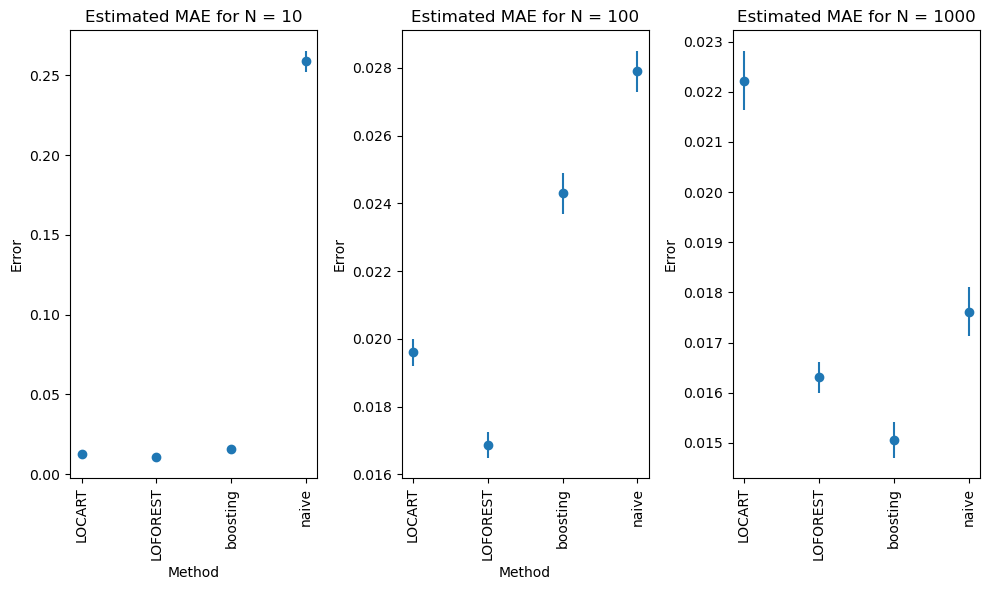

In [86]:
#| echo: false
fig, ax = plt.subplots(ncols=3, figsize=(10, 6))
# data for first subplot
data_10 = coverage_data_N_1000[0].query("N == 10")
keys = data_10.iloc[:, 0].values
mae = data_10.iloc[:, 2].values
std_err = data_10.iloc[:, 3].values
ax[0].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[0].set_xlabel("Method")
ax[0].set_ylabel("Error")
ax[0].set_title("Estimated MAE for N = 10")


data_100 = coverage_data_N_1000[0].query("N == 100")
keys = data_100.iloc[:, 0].values
mae = data_100.iloc[:, 2].values
std_err = data_100.iloc[:, 3].values
ax[1].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[1].set_xlabel("Method")
ax[1].set_ylabel("Error")
ax[1].set_title("Estimated MAE for N = 100")


data_1000 = coverage_data_N_1000[0].query("N == 1000")
keys = data_1000.iloc[:, 0].values
mae = data_1000.iloc[:, 2].values
std_err = data_1000.iloc[:, 3].values
ax[2].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[2].set_ylabel("Error")
ax[2].set_title("Estimated MAE for N = 1000")

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_11734/4135134797.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


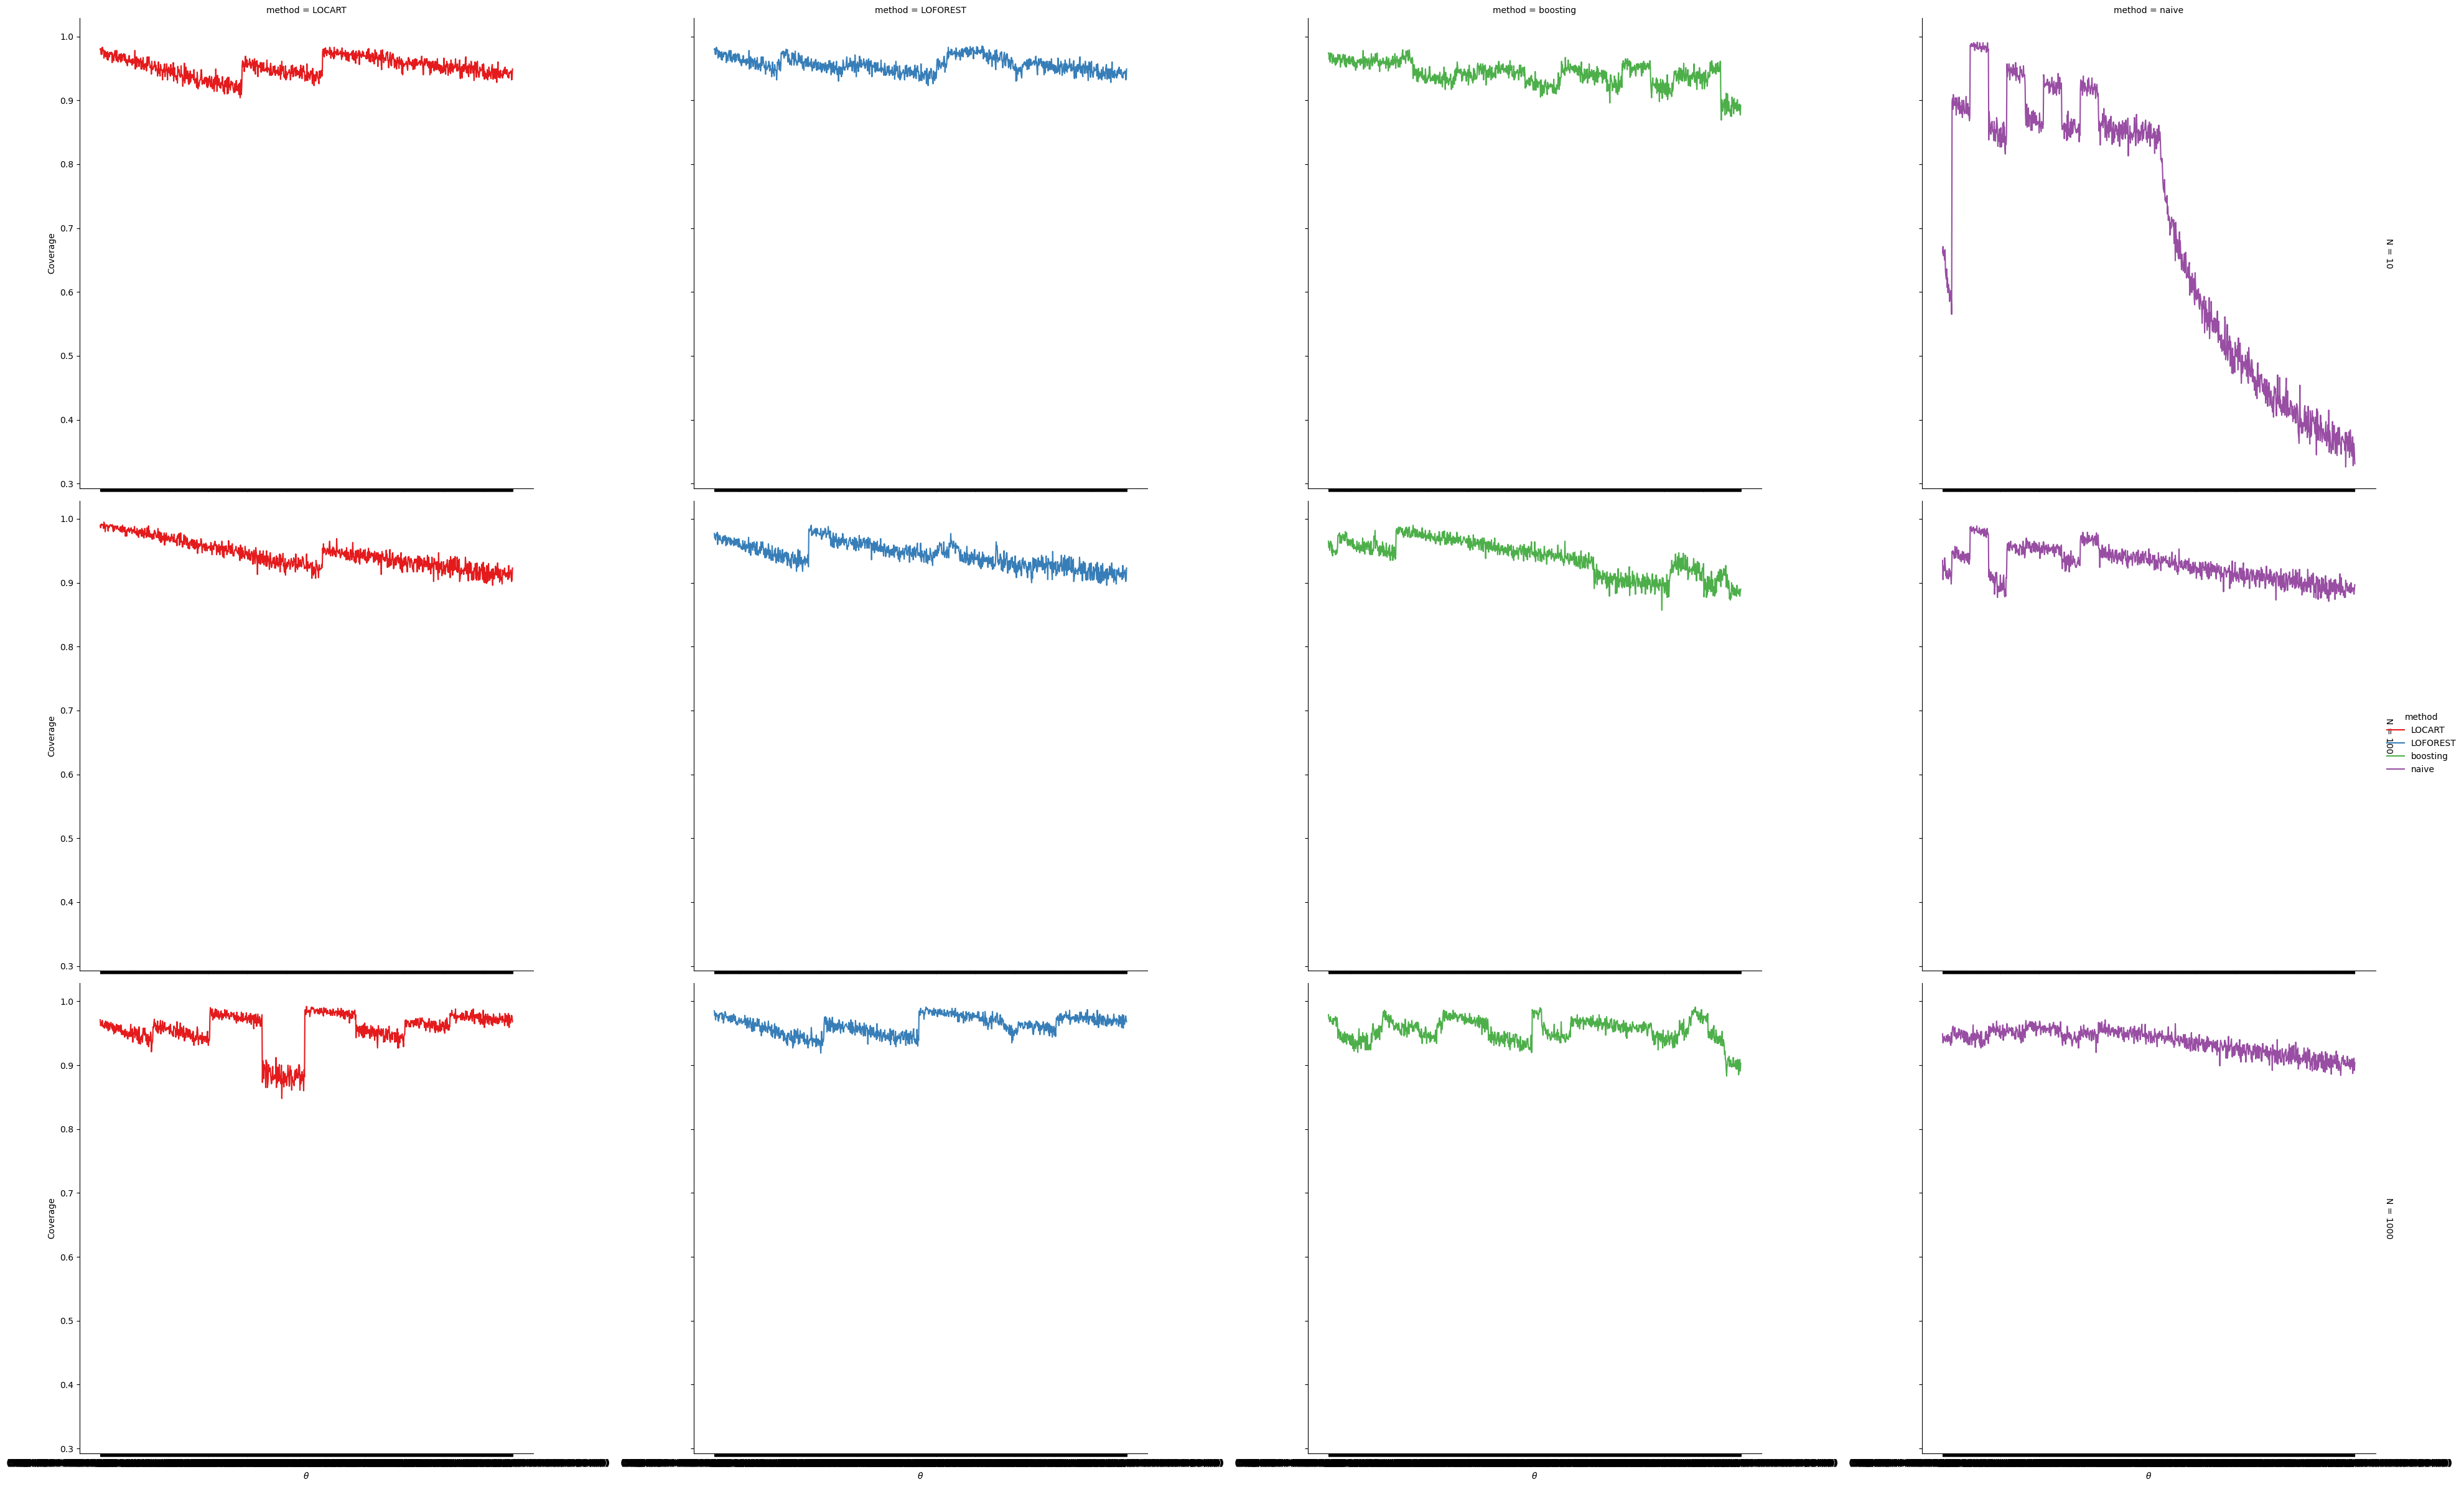

In [87]:
#| echo: false
# plotting coverage
coverage_data_melted = pd.melt(
    coverage_data_N_1000[1],
    id_vars=["thetas", "N"],
    var_name="method",
    value_name="coverage",
)
# Plot the coverage as function of the thetas generated
g = sns.FacetGrid(
    coverage_data_melted,
    row="N",
    col="method",
    hue="method",
    height= 8,
    aspect=1.20,
    palette="Set1",
    margin_titles = True
)
g.map(sns.lineplot, "thetas", "coverage")
g.add_legend()
g.set_titles("{col_name}")
g.set_xlabels(r"$\theta$")
g.set_ylabels("Coverage")
plt.tight_layout()
plt.show()

## new example

In this case, $\Theta = (50, 150) \times (2, 8)$

In [88]:
# simulator
def sim_gamma(gamma_shape, gamma_scale, n, threshold=None):
    
    random_x = np.random.gamma(gamma_shape, gamma_scale, n)

    if not threshold:
        threshold = np.random.choice(random_x)

    emp_prob = np.mean(random_x > threshold)
    t_prob = 1 - stats.gamma.cdf(threshold, a=gamma_shape, scale=gamma_scale)

    lambda_stat = np.abs(t_prob - emp_prob)

    return lambda_stat

# randomly sampling from gamma
def sample_gamma(n, N, seed=1000, threshold = None):
    np.random.seed(seed)
    thetas = np.c_[np.random.uniform(2, 8, n),np.random.uniform(50, 150, n)]
    lambdas = np.zeros(n)
    i = 0
    for shape, scale in thetas:
        lambdas[i] = sim_gamma(gamma_shape=shape, gamma_scale=scale, n=N, threshold = threshold)
        i += 1
    return thetas, lambdas


# naive method
def naive(alpha, B=1000, N=100, seed=250, naive_n=100, threshold = None):
    np.random.seed(seed)
    n_grid = int(B / naive_n)
    a_s = np.linspace(50.0001, 149.9999, n_grid)
    b_s = np.linspace(2.0001, 7.9999, n_grid)
    
    quantiles = {}
    for shape, scale in itertools.product(b_s, a_s):
        lambda_stat = np.zeros(int(np.sqrt(naive_n)))
        for i in range(int(np.sqrt(naive_n))):
            lambda_stat[i] = sim_gamma(
                gamma_shape=shape, 
                gamma_scale=scale, 
                n = N, 
                threshold = threshold,)

        quantiles[(shape, scale)] = np.quantile(lambda_stat, q=1 - alpha)
    return quantiles


# naive predict function
def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for x in theta_grid:
        distances = np.linalg.norm(thetas_values - x, axis=1)
        idx = thetas_values[np.argmin(distances)]
        quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list

In [89]:
def evaluate_coverage(quantiles_dict, thetas, alpha=0.05, n=1000, N=100):
    err_data = np.zeros((thetas.shape[0], 4))
    coverage_data = np.zeros((thetas.shape[0], 4))
    j = 0
    for theta in tqdm(thetas, desc="Computing coverage for each method"):
        # generating several lambdas
        stat = np.zeros(n)
        for i in range(0, n):
            stat[i] = sim_gamma(gamma_shape=theta[0], gamma_scale=theta[1], n=N)
            
        # comparing coverage of methods
        locart_cover = np.mean(stat <= quantiles_dict["locart"][j])
        loforest_cover = np.mean(stat <= quantiles_dict["loforest"][j])
        boosting_cover = np.mean(stat <= quantiles_dict["boosting"][j])
        naive_cover = np.mean(stat <= quantiles_dict["naive"][j])

        # appending the errors
        err_locart = np.abs(locart_cover - (1 - alpha))
        err_loforest = np.abs(loforest_cover - (1 - alpha))
        err_boosting = np.abs(boosting_cover - (1 - alpha))
        err_naive = np.abs(naive_cover - (1 - alpha))

        # saving in numpy array
        err_data[j, :] = np.array([err_locart, err_loforest, err_boosting, err_naive])
        coverage_data[j, :] = np.array(
            [locart_cover, loforest_cover, boosting_cover, naive_cover]
        )
        j += 1

    # obtaining MAE and standard error for each method
    mae_vector, std_vector = np.mean(err_data, axis=0), np.std(err_data, axis=0)
    stats_data = pd.DataFrame(
        {
            "methods": ["LOCART", "LOFOREST", "boosting", "naive"],
            "MAE": mae_vector,
            "str": std_vector / (np.sqrt(thetas.shape[0])),
        }
    )

    coverage_data = pd.DataFrame(
        {
            "thetas": [str(tuple(row)) for row in thetas],
            "LOCART": coverage_data[:, 0],
            "LOFOREST": coverage_data[:, 1],
            "boosting": coverage_data[:, 2],
            "naive": coverage_data[:, 3],
        }
    )
    return [stats_data, coverage_data]

In [90]:
N, B, alpha = 100, 1000, 0.05

Fitting naive:

In [91]:
start_time = time.time()
naive_quantiles = naive(alpha, B = B, N = N)
end_time = time.time()

running_time = end_time - start_time
print(f"Naive running time: {running_time} seconds.")

Naive running time: 0.08947062492370605 seconds.


Sampling $\theta$ and $\lambda$ to fit the models:


In [92]:
model_thetas, model_lambdas = sample_gamma(n = B, N = N, seed = 45)

Fitting all other methods:

In [93]:
start_time = time.time()
locart_object = LocartSplit(LambdaScore, None, alpha = alpha, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 100)
end_time = time.time()
print(f"LOCART running time: {end_time - start_time} seconds.")

# loforest quantiles
start_time = time.time()
loforest_object = ConformalLoforest(LambdaScore, None, alpha = alpha, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 300)
end_time = time.time()
print(f"LOFOREST running time: {end_time - start_time} seconds.")

# boosting quantiles
start_time = time.time()
model = HistGradientBoostingRegressor(loss="quantile", max_iter = 1000,
    quantile = 1 - alpha, random_state = 105, n_iter_no_change = 20, early_stopping = True)
model.fit(model_thetas, model_lambdas)
end_time = time.time()
print(f"Boosting running time: {end_time - start_time} seconds.")

LOCART running time: 0.0058939456939697266 seconds.
LOFOREST running time: 0.12365436553955078 seconds.
Boosting running time: 0.10793876647949219 seconds.


Generating 2d grid for $\theta$:

In [94]:
n_out = 50
a_s = np.linspace(50.0001, 149.9999, n_out)
b_s = np.linspace(2.0001, 7.9999, n_out)
thetas_grid = np.c_[list(itertools.product(a_s, b_s))]
# printing grid size
thetas_grid.shape[0]

2500

In [95]:
# naive quantiles
naive_list = predict_naive_quantile(thetas_grid, naive_quantiles)

# locart quantiles
idxs = locart_object.cart.apply(thetas_grid)
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

# loforest
loforest_cutoffs = loforest_object.compute_cutoffs(thetas_grid)

# boosting
boosting_quantiles = model.predict(thetas_grid)

# dictionary of quantiles
quantile_dict = {
    "naive": naive_list,
    "locart": list_locart_quantiles,
    "loforest": loforest_cutoffs,
    "boosting": boosting_quantiles,
}

In [97]:
cover_data = evaluate_coverage(quantile_dict, thetas = thetas_grid, n = 1000)

Computing coverage for each method: 100%|██████████| 2500/2500 [03:18<00:00, 12.57it/s]


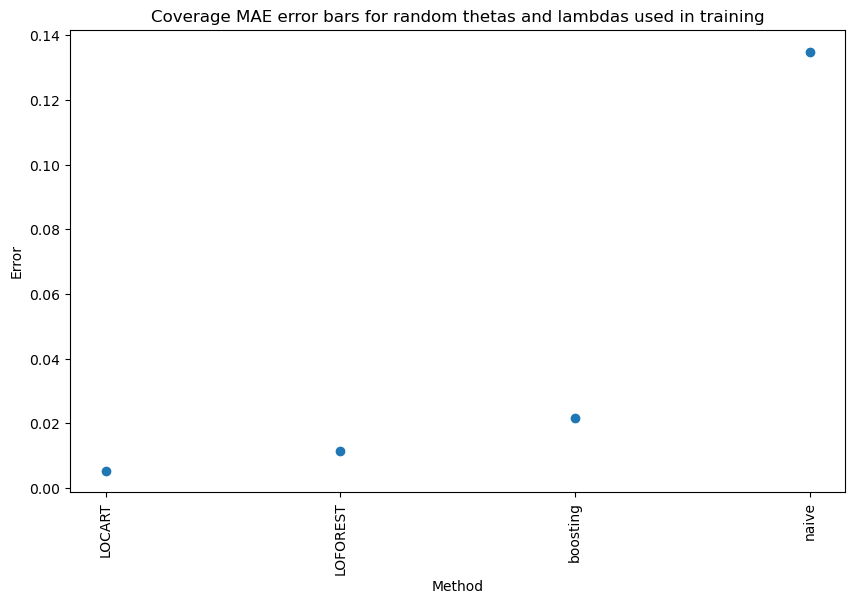

In [98]:
#| echo: false
keys = cover_data[0].iloc[:, 0].values
mae = cover_data[0].iloc[:, 1].values
std_err = cover_data[0].iloc[:, 2].values

plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars for random thetas and lambdas used in training')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


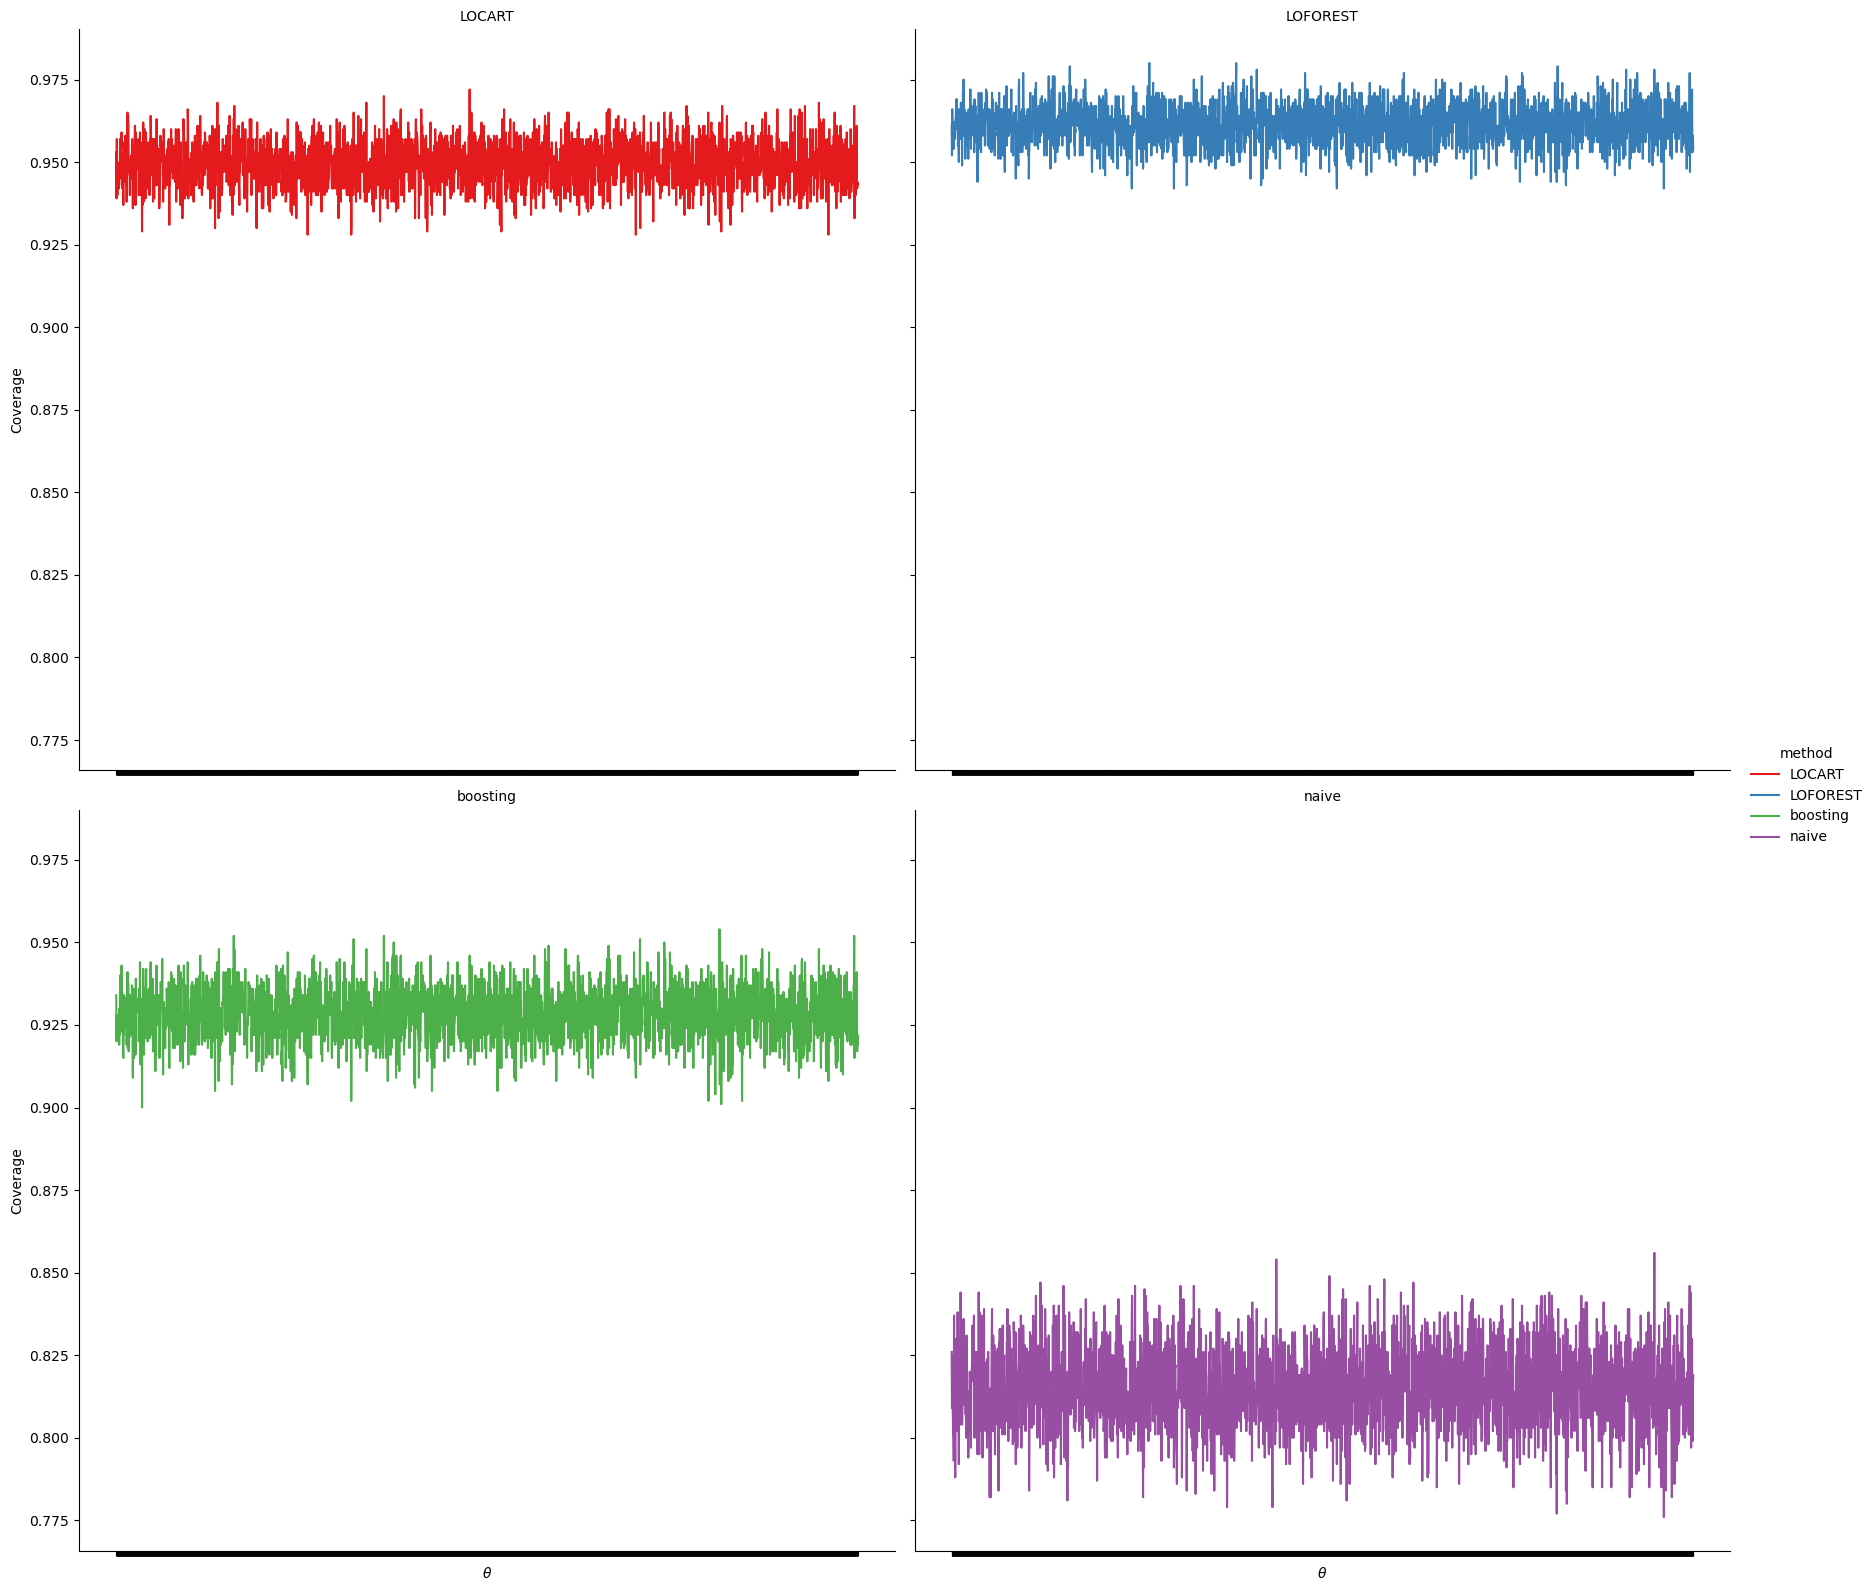

In [99]:
#| echo: false
# Melt the coverage data
coverage_data_melted = pd.melt(
    cover_data[1], id_vars=["thetas"], var_name="method", value_name="coverage")
# Plot the coverage as function of the thetas generated
g = sns.FacetGrid(coverage_data_melted, col="method", hue = "method",
 col_wrap = 2, height=8, aspect=1.10, palette = "Set1")
g.set(xticklabels=[])
g.map(sns.lineplot, "thetas", "coverage")
g.add_legend()
g.set_titles("{col_name}")
g.set_xlabels(r"$\theta$")
g.set_ylabels("Coverage")
plt.show()